# Постановка задачи

**Цель:** Выявить влияние продуктов на продолжительность жизни

**Данные:**

**Ожидаемая продолжительность жизни при рождении (ЕМИСС):**

https://www.fedstat.ru/indicator/31293

**Потребление основных продуктов питания (Росстат):**

https://rosstat.gov.ru/compendium/document/13278


**Социально-экономические, демографические, здравоохрание:**

https://tochno.st/datasets/regions_collection

**Экология:**

https://tochno.st/datasets/air_cities

**Целевая переменная:**

Y - Ожидаемая продолжительность жизни ежегодно по регионам РФ 2011-2021г

**Питание:**

x1 - Потребление мяса (на душу населения в год, кг) по регионам РФ 2011-2021г

x2 - Потребление молока (на душу населения в год, кг) по регионам РФ 2011-2021г

x3 - Потребление яиц (на душу населения в год, кг) по регионам РФ 2011-2021г

x4 - Потребление картофеля (на душу населения в год, кг) по регионам РФ 2011-2021г

x5 - Потребление овощей (на душу населения в год, кг) по регионам РФ 2011-2021г

x6 - Потребление фруктов (на душу населения в год, кг) по регионам РФ 2011-2021г

x7 - Потребление хлебных продуктов (на душу населения в год, кг) по регионам РФ 2011-2021г

x8 - Потребление масла растительного (на душу населения в год, кг) по регионам
РФ 2011-2021г

x9 - Потребление сахара (на душу населения в год, кг) по регионам РФ 2011-2021г


**Социально-экономические:**

x10 - Среднедушевые денежные доходы населения в месяц, рублей

x11 - Численность населения с денежными доходами ниже границы бедности/величины прожиточного минимума в процентах от общей численности населения субъекта

x12 - Выпуск бакалавров, специалистов, магистров (тысяч человек)

**Медицинские(здравоохранение):**

x13 - Заболеваемость на 1000 человек населения, зарегистрировано заболеваний у пациентов с диагнозом, установленным впервые в жизни

x14 - Численность врачей всех специальностей: На 10 000 человек населения (человек)

x15 - Численность населения на одну больничную койку, на конец года, человек

**Демографические факторы:**

x16 - Численность населения, оценка на конец года, тысяч человек

x17 - Соотношение мужчин и женщин, оценка на конец года, на 1000 мужчин приходится женщин

x18 - Численность пенсионеров на 1000 человек

**Экологические факторы:**

x19 - Уровень загрязнения воздуха (низкий, повышенный, высокий, очень высокий)

# Предобработка данных

Библиотеки

In [ ]:
import pandas as pd

Функции

In [ ]:
def clean_reg(name):
  return name.replace(' ', '').replace('г.', '').replace('–', '').replace('-', '').lower()

def del_reg(df):
  return df.loc[
    (df['region'] != 'Российская Федерация') & # не регион
    (~df['region'].str.contains('округ', case=False)) & # не регион
    (~df['region'].str.contains('Крым', case=False)) & # данные с 2014 года
    (~df['region'].str.contains('Севастополь', case=False))& # данные с 2014 года
    (~df['region'].str.contains('Чеченская и Ингушская', case=False)) & # неполнные данные
    (~df['region'].str.contains('Костромская', case=False)) & # неполнные данные
    (~df['region'].str.contains('Томская', case=False)) # неполнные данные
    ].drop_duplicates(subset=['region'], keep='first').reset_index(drop=True)

Загружаем и фильтруем Y - ожидаемую продолжительность жизни

In [ ]:
df_y = pd.read_excel('data.xls', header = 2)
df_y.columns = ['region', 'gender', 'category', 'type'] + list(df_y.columns[4:])

df_y = df_y[(df_y['gender'] == 'Оба пола') & (df_y['category'] == 'все население')] # Фильтрация
df_y = df_y[['region'] + [str(year) for year in range(2011, 2022)]] # Оставляем только нужные нам даты и названия регионов
df_y = df_y = df_y.reset_index(drop=True) # Сброс индексов

Загружаем Иксы: потребление продуктов питания

In [ ]:
xls = pd.ExcelFile('Potreb_Svod_2011-2021.xlsx')

dfs_x = {}
for sheet_name in xls.sheet_names[1:]:  # Начинаем с индекса 1, чтобы пропустить первый лист "содержание"
    df = pd.read_excel(xls, sheet_name=sheet_name, header=4)  # Читаем данные с заголовком на 4-й строке
    df.columns = ['region'] + list(df.columns[1:])
    dfs_x[sheet_name] = df  # Сохраняем DataFrame в словаре по имени листа

Чистим названия регионов у Y (они не совпдают с названиями регионов у Иксов)

In [ ]:
for region in dfs_x['мясо'].region.unique():
  for i in range(len(df_y)):
    if clean_reg(region) in clean_reg(df_y.loc[i, 'region']):
      df_y.at[i, 'region'] = region

Объединяем датасеты в один

In [ ]:
df = del_reg(df_y)
df = pd.melt(df, id_vars=['region'], var_name='year', value_name='y')
df['year'] = df['year'].astype(int)

k = 0
x_names = ''
for name, df_x in dfs_x.items():
    k += 1
    line = f"Фактор: {name}, название: x{k}"
    x_names += line + '\n'
    print(line)
    df_x = del_reg(df_x[:91])
    df_x = pd.melt(df_x, id_vars=['region'], var_name='year', value_name='x'+str(k))
    df = pd.merge(df, df_x, on=['region', 'year'], how='outer')

Фактор: мясо, название: x1
Фактор: молоко, название: x2
Фактор: яйца, название: x3
Фактор: картофель, название: x4
Фактор: овощи, название: x5
Фактор: фрукты, название: x6
Фактор: хлебные, название: x7
Фактор: масло раст, название: x8
Фактор: сахар, название: x9


Меняем тип у year и и Y

In [ ]:
df['year'], df['y'] = df['year'].astype(int), df['y'].astype(float) # стобцы year и y сделаем int и float соответственно

Промежуточная таблица

In [ ]:
df

,region,year,y,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,Алтайский край,2011,68.94,65,323,307,117.0,90.0,50.0,169,12.8,40.0
1,Алтайский край,2012,69.01,69,320,309,116.0,87.0,51.0,168,13.6,38.0
2,Алтайский край,2013,69.60,69,318,310,112.0,85.0,55.0,168,13.9,39.0
3,Алтайский край,2014,69.77,67,304,312,106.0,82.0,55.0,168,14.5,39.0
4,Алтайский край,2015,70.13,62,284,318,98.0,81.0,54.0,163,14.3,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...
842,г. Санкт-Петербург,2017,75.48,71,297,317,67.0,82.0,59.0,85,11.0,36.0
843,г. Санкт-Петербург,2018,75.97,71,289,319,63.0,82.0,58.0,82,10.8,36.0
844,г. Санкт-Петербург,2019,76.38,70,288,322,62.0,83.0,60.0,83,10.8,36.0
845,г. Санкт-Петербург,2020,74.23,71,300,335,60.0,83.0,58.0,83,10.8,36.0


Выгружаем таблицу, чтобы в программе Excel добавить остальные факторы из-за сильных различий в названии регионов у разных источников, пришлось дальше добавить факторы вручную

In [ ]:
#df.to_excel('test.xlsx')

In [ ]:
df = pd.read_excel('all_data_merged.xlsx')

In [ ]:
df.head()

,region,year,y,x1,x2,x3,x4,x5,x6,x7,...,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
0,Алтайский край,2011,68.94,65,323,307,117,90,50,169,...,12500,22.6,16.8,1054.7,50.7,92.1,2396.8,1159,292.7,3.333333
1,Алтайский край,2012,69.01,69,320,309,116,87,51,168,...,13617,20.6,16.5,1094.6,46.4,94.4,2378.0,1159,296.8,3.000000
2,Алтайский край,2013,69.60,69,318,310,112,85,55,168,...,15896,17.6,14.3,1102.2,46.3,95.3,2359.5,1160,300.7,2.333333
3,Алтайский край,2014,69.77,67,304,312,106,82,55,168,...,18291,17.1,14.8,1099.0,45.7,97.5,2343.4,1162,305.4,2.000000
4,Алтайский край,2015,70.13,62,284,318,98,81,54,163,...,20860,18.0,15.1,1118.4,43.9,100.2,2325.0,1162,309.2,1.333333


In [ ]:
df.isnull().sum()

,0
region,0
year,0
y,0
x1,0
x2,0
x3,0
x4,0
x5,0
x6,0
x7,0


In [ ]:
df.dtypes

,0
region,object
year,int64
y,float64
x1,int64
x2,int64
x3,int64
x4,int64
x5,int64
x6,int64
x7,int64


In [ ]:
df.describe()

,year,y,x1,x2,x3,x4,x5,x6,x7,x8,...,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,...,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,2016.000000,70.667745,73.694215,232.413223,262.916175,95.850059,102.439197,57.596222,118.419126,12.893270,...,26278.030697,14.490555,14.185950,799.629280,47.360921,116.210626,1855.860685,1151.696576,298.553601,1.947512
std,3.164146,2.556460,12.231697,43.232936,48.731971,25.111665,28.075182,14.126661,17.609576,2.404633,...,10052.622854,4.960592,25.433688,152.756106,9.411053,21.466303,1864.151592,47.526166,34.784407,0.908496
min,2011.000000,61.100000,36.000000,105.000000,89.000000,36.000000,38.000000,20.000000,30.000000,7.900000,...,8829.000000,5.000000,0.300000,309.200000,26.300000,68.300000,135.900000,995.000000,180.400000,1.000000
25%,2013.000000,69.090000,66.000000,200.000000,232.000000,81.000000,86.000000,48.000000,108.000000,11.300000,...,19750.000000,11.300000,4.000000,690.550000,40.650000,102.200000,796.300000,1123.000000,275.850000,1.000000
50%,2016.000000,70.450000,73.000000,232.000000,265.000000,94.000000,99.000000,57.000000,117.000000,12.400000,...,24392.000000,13.800000,7.700000,789.300000,46.700000,115.200000,1218.000000,1156.000000,299.400000,1.888889
75%,2019.000000,72.115000,80.000000,262.500000,299.500000,111.000000,110.000000,67.000000,127.000000,14.100000,...,29909.000000,16.800000,15.950000,899.300000,53.100000,126.700000,2515.050000,1184.000000,322.700000,3.000000
max,2021.000000,79.640000,120.000000,366.000000,400.000000,176.000000,245.000000,117.000000,405.000000,23.200000,...,88831.000000,37.800000,262.300000,1407.500000,87.900000,222.000000,13015.100000,1239.000000,384.900000,4.000000


Для дальнейшего удобства сделаем словарь с пояснениями про что каждый фактор

In [ ]:
factors = {'x1' : 'Потребление мяса (на душу населения в год, кг)',
           'x2' : 'Потребление молока (на душу населения в год, кг)',
           'x3' : 'Потребление яиц (на душу населения в год, кг)',
           'x4' : 'Потребление картофеля (на душу населения в год, кг)' ,
           'x5' : 'Потребление овощей (на душу населения в год, кг)' ,
           'x6' : 'Потребление фруктов (на душу населения в год, кг)',
           'x7' : 'Потребление хлебных продуктов (на душу населения в год, кг)' ,
           'x8' : 'Потребление масла растительного (на душу населения в год, кг)',
           'x9' : 'Потребление сахара (на душу населения в год, кг)',
           'x10' : 'Среднедушевые денежные доходы населения в месяц, рублей',
           'x11' : 'Численность населения с денежными доходами ниже границы бедности/величины прожиточного минимума в процентах от общей численности населения субъекта',
           'x12' : 'Выпуск бакалавров, специалистов, магистров (тысяч человек)',
           'x13' : 'Заболеваемость на 1000 человек населения, зарегистрировано заболеваний у пациентов с диагнозом, установленным впервые в жизни',
           'x14' : 'Численность врачей всех специальностей: На 10 000 человек населения (человек)',
           'x15' : 'Численность населения на одну больничную койку, на конец года, человек',
           'x16' : 'Численность населения, оценка на конец года, тысяч человек',
           'x17' : 'Соотношение мужчин и женщин, оценка на конец года, на 1000 мужчин приходится женщин',
           'x18' : 'Численность пенсионеров на 1000 человек',
           'x19' : 'Уровень загрязнения воздуха (низкий, повышенный, высокий, очень высокий)'

}

In [ ]:
df.head()

,region,year,y,x1,x2,x3,x4,x5,x6,x7,...,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
0,Алтайский край,2011,68.94,65,323,307,117,90,50,169,...,12500,22.6,16.8,1054.7,50.7,92.1,2396.8,1159,292.7,3.333333
1,Алтайский край,2012,69.01,69,320,309,116,87,51,168,...,13617,20.6,16.5,1094.6,46.4,94.4,2378.0,1159,296.8,3.000000
2,Алтайский край,2013,69.60,69,318,310,112,85,55,168,...,15896,17.6,14.3,1102.2,46.3,95.3,2359.5,1160,300.7,2.333333
3,Алтайский край,2014,69.77,67,304,312,106,82,55,168,...,18291,17.1,14.8,1099.0,45.7,97.5,2343.4,1162,305.4,2.000000
4,Алтайский край,2015,70.13,62,284,318,98,81,54,163,...,20860,18.0,15.1,1118.4,43.9,100.2,2325.0,1162,309.2,1.333333


# Корреляция

Библиотеки

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Оценка корреляции продуктов питания

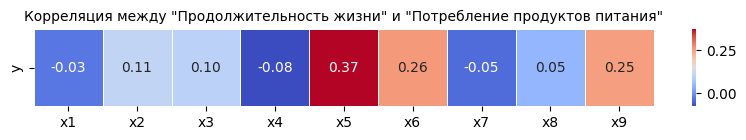

In [ ]:
df_corr = df.drop(columns=['region', 'year'])

correlation_matrix = df_corr.corr()

y_corr = correlation_matrix.loc['y', 'x1':'x9']

plt.figure(figsize=(10, 1))
sns.heatmap(y_corr.to_frame().T, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляция между "Продолжительность жизни" и "Потребление продуктов питания"', fontsize=10)
plt.show()

Корреляция всех

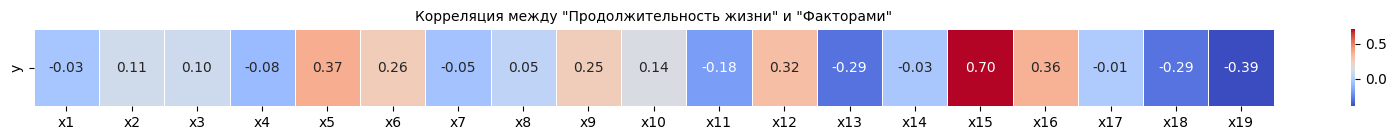

In [ ]:
df_corr = df.drop(columns=['region', 'year'])

correlation_matrix = df_corr.corr()

y_corr = correlation_matrix.loc['y', 'x1':'x19']

plt.figure(figsize=(20, 1))
sns.heatmap(y_corr.to_frame().T, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляция между "Продолжительность жизни" и "Факторами"', fontsize=10)
plt.show()

# Статистическая значимость перменных

Проверим статистическую значимость перменных, построив линейную модель на каждом из факторов по-очереди

H0: Нет связи между Y и Xi

H1: Есть связь между Y и Xi

Значение p-value > 0.05 => H0

Значение p-value < 0.05 => H1

In [ ]:
import statsmodels.api as sm

In [ ]:
h0_factors = [] # сюда незначимые факторы добавим

for i in range(1, 20):
  y = df['y']
  X = df[f'x{i}']
  X = sm.add_constant(X)
  model = sm.OLS(y, X).fit()
  p_value = model.pvalues[f'x{i}']
  h = 'H1' if p_value<0.05 else 'H0'
  if h == 'H0': h0_factors.append(f'x{i}')
  print(f'X{i}, pvalue: {round(p_value, 4)}, => {h}')

X1, pvalue: 0.3299, => H0
X2, pvalue: 0.0021, => H1
X3, pvalue: 0.0049, => H1
X4, pvalue: 0.0237, => H1
X5, pvalue: 0.0, => H1
X6, pvalue: 0.0, => H1
X7, pvalue: 0.1847, => H0
X8, pvalue: 0.1842, => H0
X9, pvalue: 0.0, => H1
X10, pvalue: 0.0001, => H1
X11, pvalue: 0.0, => H1
X12, pvalue: 0.0, => H1
X13, pvalue: 0.0, => H1
X14, pvalue: 0.4055, => H0
X15, pvalue: 0.0, => H1
X16, pvalue: 0.0, => H1
X17, pvalue: 0.8575, => H0
X18, pvalue: 0.0, => H1
X19, pvalue: 0.0, => H1


Незначимые факторы

In [ ]:
for factor in h0_factors:
  print(factor, factors[factor])

x1 Потребление мяса (на душу населения в год, кг)
x7 Потребление хлебных продуктов (на душу населения в год, кг)
x8 Потребление масла растительного (на душу населения в год, кг)
x14 Численность врачей всех специальностей: На 10 000 человек населения (человек)
x17 Соотношение мужчин и женщин, оценка на конец года, на 1000 мужчин приходится женщин


# Мультиколлинеарность

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Функция для вычисления VIF для каждой переменной
def find_vif(X):
  vif_data = pd.DataFrame()
  vif_data["Variable"] = X.columns
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  print(vif_data)
  max_vif_row = vif_data.loc[vif_data['VIF'].idxmax()] # id строки с max vif
  variable_with_max_vif = max_vif_row['Variable'] # фактор
  max_vif_value = max_vif_row['VIF'] # значение vif
  print('----------------------------')
  print(f'Max VIF: {max_vif_value}')
  print(f'Factor: {variable_with_max_vif} - {factors[variable_with_max_vif]}')

In [ ]:
X = df.drop(['region', 'year', 'y'], axis=1)
y = df['y']

In [ ]:
find_vif(X)

   Variable         VIF
0        x1   46.749035
1        x2   41.167883
2        x3   62.605747
3        x4   18.800480
4        x5   22.527192
5        x6   30.213664
6        x7   54.845533
7        x8   42.780010
8        x9   47.891171
9       x10   16.986040
10      x11   19.329184
11      x12    6.265058
12      x13   39.393596
13      x14   44.826281
14      x15   51.206165
15      x16   11.994759
16      x17  591.040254
17      x18  236.875830
18      x19    7.106786
----------------------------
Max VIF: 591.0402541478541
Factor: x17 - Соотношение мужчин и женщин, оценка на конец года, на 1000 мужчин приходится женщин


Избавляемся от переменных

In [ ]:
X = X.drop(['x17'], axis=1)

In [ ]:
find_vif(X)

   Variable         VIF
0        x1   46.564275
1        x2   37.890785
2        x3   62.372232
3        x4   18.282951
4        x5   22.212707
5        x6   30.046547
6        x7   54.401448
7        x8   42.345242
8        x9   46.859739
9       x10   16.775792
10      x11   16.496996
11      x12    6.228528
12      x13   39.284085
13      x14   40.312906
14      x15   40.780172
15      x16   11.875550
16      x18  114.754442
17      x19    6.880291
----------------------------
Max VIF: 114.75444169921929
Factor: x18 - Численность пенсионеров на 1000 человек


In [ ]:
X = X.drop(['x18'], axis=1)

In [ ]:
find_vif(X)

   Variable        VIF
0        x1  44.011570
1        x2  37.041989
2        x3  56.381809
3        x4  17.921540
4        x5  21.065860
5        x6  29.347534
6        x7  53.916927
7        x8  38.756269
8        x9  45.957897
9       x10  16.438297
10      x11  16.496994
11      x12   6.212941
12      x13  31.094421
13      x14  40.287922
14      x15  40.025083
15      x16  10.766529
16      x19   6.754443
----------------------------
Max VIF: 56.381809388564974
Factor: x3 - Потребление яиц (на душу населения в год, кг)


In [ ]:
X = X.drop(['x3'], axis=1)

In [ ]:
find_vif(X)

   Variable        VIF
0        x1  43.032185
1        x2  35.998752
2        x4  17.857609
3        x5  21.063450
4        x6  28.639017
5        x7  53.697603
6        x8  34.315460
7        x9  45.878322
8       x10  15.839907
9       x11  14.667590
10      x12   5.530864
11      x13  28.942240
12      x14  37.287750
13      x15  39.969382
14      x16   9.851668
15      x19   6.719599
----------------------------
Max VIF: 53.6976030860921
Factor: x7 - Потребление хлебных продуктов (на душу населения в год, кг)


In [ ]:
X = X.drop(['x7'], axis=1)

In [ ]:
find_vif(X)

   Variable        VIF
0        x1  42.920090
1        x2  35.967277
2        x4  17.348485
3        x5  20.827773
4        x6  27.905989
5        x8  33.466079
6        x9  40.161357
7       x10  15.801617
8       x11  13.824627
9       x12   5.482730
10      x13  28.564491
11      x14  37.182059
12      x15  39.267974
13      x16   9.841531
14      x19   6.536386
----------------------------
Max VIF: 42.92009036126923
Factor: x1 - Потребление мяса (на душу населения в год, кг)


In [ ]:
X = X.drop(['x1'], axis=1)

In [ ]:
find_vif(X)

   Variable        VIF
0        x2  32.503661
1        x4  17.082546
2        x5  20.684378
3        x6  27.846901
4        x8  32.698101
5        x9  38.222684
6       x10  14.545450
7       x11  13.401176
8       x12   5.416225
9       x13  28.554843
10      x14  36.818143
11      x15  39.236023
12      x16   9.824282
13      x19   6.518141
----------------------------
Max VIF: 39.23602277826294
Factor: x15 - Численность населения на одну больничную койку, на конец года, человек


In [ ]:
X = X.drop(['x15'], axis=1)

In [ ]:
find_vif(X)

   Variable        VIF
0        x2  30.371661
1        x4  15.855781
2        x5  19.957528
3        x6  27.804845
4        x8  32.407594
5        x9  34.841691
6       x10  13.807134
7       x11  11.277051
8       x12   5.380404
9       x13  28.425689
10      x14  35.059960
11      x16   9.100020
12      x19   6.307219
----------------------------
Max VIF: 35.05995996073462
Factor: x14 - Численность врачей всех специальностей: На 10 000 человек населения (человек)


In [ ]:
X = X.drop(['x14'], axis=1)

In [ ]:
find_vif(X)

   Variable        VIF
0        x2  29.784251
1        x4  15.799409
2        x5  19.919589
3        x6  27.721139
4        x8  32.314814
5        x9  34.169208
6       x10  11.079403
7       x11  10.763360
8       x12   4.904102
9       x13  26.688248
10      x16   8.357211
11      x19   6.059217
----------------------------
Max VIF: 34.169208360410764
Factor: x9 - Потребление сахара (на душу населения в год, кг)


In [ ]:
X = X.drop(['x9'], axis=1)

In [ ]:
find_vif(X)

   Variable        VIF
0        x2  29.025116
1        x4  14.502966
2        x5  19.718269
3        x6  25.543981
4        x8  29.061408
5       x10  10.966331
6       x11  10.763267
7       x12   4.904087
8       x13  26.683919
9       x16   8.350926
10      x19   6.007994
----------------------------
Max VIF: 29.061407827770704
Factor: x8 - Потребление масла растительного (на душу населения в год, кг)


In [ ]:
X = X.drop(['x8'], axis=1)

In [ ]:
find_vif(X)

  Variable        VIF
0       x2  27.717819
1       x4  14.152702
2       x5  18.984221
3       x6  25.178960
4      x10  10.418060
5      x11  10.538823
6      x12   4.896733
7      x13  26.021539
8      x16   8.234812
9      x19   6.003003
----------------------------
Max VIF: 27.71781912804073
Factor: x2 - Потребление молока (на душу населения в год, кг)


In [ ]:
X = X.drop(['x2'], axis=1)

In [ ]:
find_vif(X)

  Variable        VIF
0       x4  13.943837
1       x5  18.096913
2       x6  24.613551
3      x10  10.412489
4      x11   9.915311
5      x12   4.896621
6      x13  21.680368
7      x16   8.091401
8      x19   5.995525
----------------------------
Max VIF: 24.613551080978205
Factor: x6 - Потребление фруктов (на душу населения в год, кг)


In [ ]:
X = X.drop(['x6'], axis=1)

In [ ]:
find_vif(X)

  Variable        VIF
0       x4  13.548681
1       x5  11.294185
2      x10   9.283453
3      x11   9.614674
4      x12   4.884793
5      x13  20.897810
6      x16   8.046323
7      x19   5.933507
----------------------------
Max VIF: 20.897810384665025
Factor: x13 - Заболеваемость на 1000 человек населения, зарегистрировано заболеваний у пациентов с диагнозом, установленным впервые в жизни


In [ ]:
X = X.drop(['x13'], axis=1)

In [ ]:
find_vif(X)

  Variable        VIF
0       x4  11.852822
1       x5  11.202036
2      x10   7.162615
3      x11   8.429334
4      x12   4.825977
5      x16   8.002733
6      x19   5.676290
----------------------------
Max VIF: 11.852822428283824
Factor: x4 - Потребление картофеля (на душу населения в год, кг)


In [ ]:
X = X.drop(['x4'], axis=1)

In [ ]:
find_vif(X)

  Variable       VIF
0       x5  9.439803
1      x10  6.921307
2      x11  7.495760
3      x12  4.793158
4      x16  7.999198
5      x19  5.162128
----------------------------
Max VIF: 9.43980330930749
Factor: x5 - Потребление овощей (на душу населения в год, кг)


In [ ]:
X = X.drop(['x5'], axis=1)

In [ ]:
find_vif(X)

  Variable       VIF
0      x10  5.853441
1      x11  5.463994
2      x12  4.529420
3      x16  7.451493
4      x19  5.067744
----------------------------
Max VIF: 7.451492709143343
Factor: x16 - Численность населения, оценка на конец года, тысяч человек


In [ ]:
X = X.drop(['x16'], axis=1)

In [ ]:
find_vif(X)

  Variable       VIF
0      x10  4.676528
1      x11  5.418519
2      x12  1.677704
3      x19  4.995283
----------------------------
Max VIF: 5.418518607920792
Factor: x11 - Численность населения с денежными доходами ниже границы бедности/величины прожиточного минимума в процентах от общей численности населения субъекта


In [ ]:
X = X.drop(['x11'], axis=1)

In [ ]:
find_vif(X)

  Variable       VIF
0      x10  3.584105
1      x12  1.509722
2      x19  3.139488
----------------------------
Max VIF: 3.5841047774563415
Factor: x10 - Среднедушевые денежные доходы населения в месяц, рублей


после чистки осталось совсем мало факторов, однако в них нет эффекта мультиколлинеарности

In [ ]:
for factor in X:
  print(factor, factors[factor])

x10 Среднедушевые денежные доходы населения в месяц, рублей
x12 Выпуск бакалавров, специалистов, магистров (тысяч человек)
x19 Уровень загрязнения воздуха (низкий, повышенный, высокий, очень высокий)


# Модель на всех факторах без преобразования данных

In [ ]:
import statsmodels.api as sm

In [ ]:
X = df.drop(['region', 'year', 'y'], axis=1)
y = df['y']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     108.3
Date:                Fri, 21 Mar 2025   Prob (F-statistic):          3.48e-209
Time:                        11:13:13   Log-Likelihood:                -1467.1
No. Observations:                 847   AIC:                             2974.
Df Residuals:                     827   BIC:                             3069.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.3924      1.863     33.487      0.0